# Import libraries

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import seaborn as sns
import numpy as np
from windrose import WindroseAxes
from scipy.stats import pearsonr, spearmanr

# Read the Dataset

In [21]:
df = pd.read_csv('../data/benin-malanville.csv', parse_dates=['Timestamp'])
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

### How many rows have values of zero overall 

In [23]:
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

for col in columns_to_check:
    total = len(df[col])
    zeros = (df[col] == 0).sum()
    percent_zeros = (zeros / total) * 100
    print(f"{col}: {percent_zeros:.2f}% zeros")

GHI: 0.07% zeros
DNI: 1.12% zeros
DHI: 0.07% zeros
ModA: 46.72% zeros
ModB: 46.80% zeros
WS: 12.97% zeros
WSgust: 12.19% zeros


# Pre-processing step

In [24]:
# List of columns to clean as they consist of negative values
columns_to_clean = ['GHI', 'DNI', 'DHI']

# Replace negative values with 0 in the specified columns
df[columns_to_clean] = df[columns_to_clean].clip(lower=0)

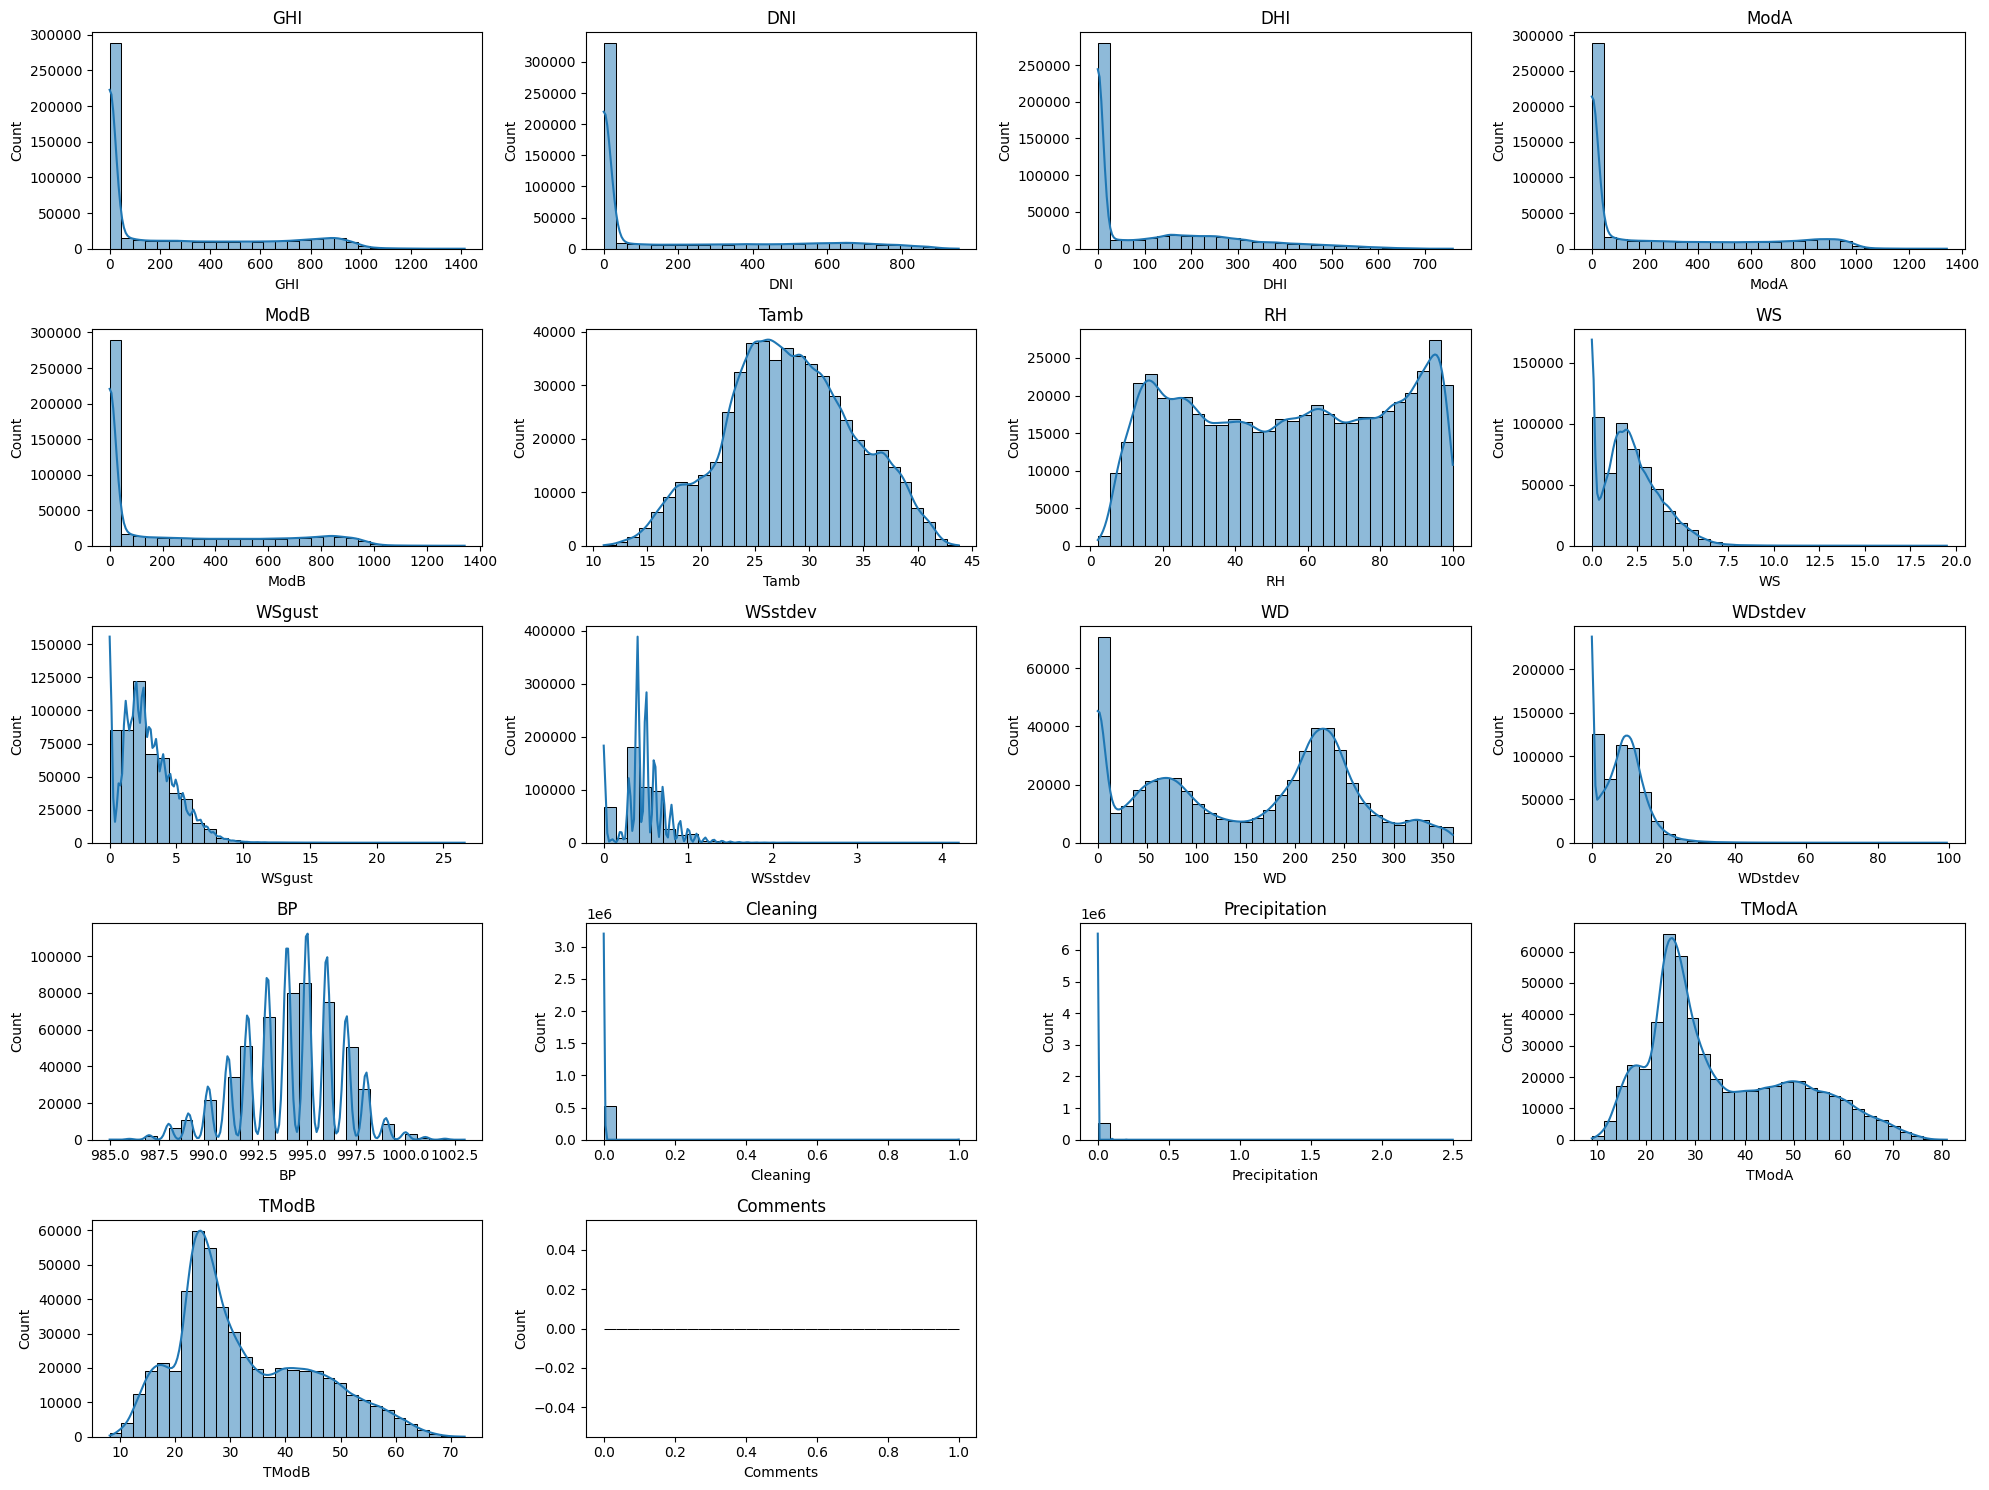

In [25]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms
plt.figure(figsize=(20, 15))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()


# Summary Statistics & Missing Values

In [26]:
df.describe()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-02-07 12:00:30.000000512,241.958821,167.441866,116.993033,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
min,2021-08-09 00:01:00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,2021-11-08 06:00:45,0.000000,0.000000,0.000000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,2022-02-07 12:00:30,1.800000,0.000000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,2022-05-09 18:00:15,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,2022-08-09 00:00:00,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN
std,NaN,330.101787,261.547532,157.463619,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN


In [43]:
df['RH'].describe()

count    500.000000
mean      54.097570
std       14.274673
min       30.231601
25%       41.454962
50%       53.591078
75%       66.316841
max       79.985884
Name: RH, dtype: float64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

In [28]:
df.shape

(525600, 19)

In [29]:
df.isna().sum()

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

In [30]:
df['Cleaning'].unique()

array([0, 1])

In [31]:
(df.isna().mean() * 100).sort_values(ascending=False)  # Percent nulls

Comments         100.0
WSstdev            0.0
TModB              0.0
TModA              0.0
Precipitation      0.0
Cleaning           0.0
BP                 0.0
WDstdev            0.0
WD                 0.0
Timestamp          0.0
GHI                0.0
WS                 0.0
RH                 0.0
Tamb               0.0
ModB               0.0
ModA               0.0
DHI                0.0
DNI                0.0
WSgust             0.0
dtype: float64

### Drop the `Comments` column

In [32]:
df.drop(columns=['Comments'], inplace=True)

### Outliers Detection

In [33]:
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[cols_to_check].apply(zscore)

outliers = (z_scores.abs() > 3).sum()
outliers

GHI         90
DNI          2
DHI       3889
ModA        27
ModB        63
WS        3109
WSgust    3500
dtype: int64

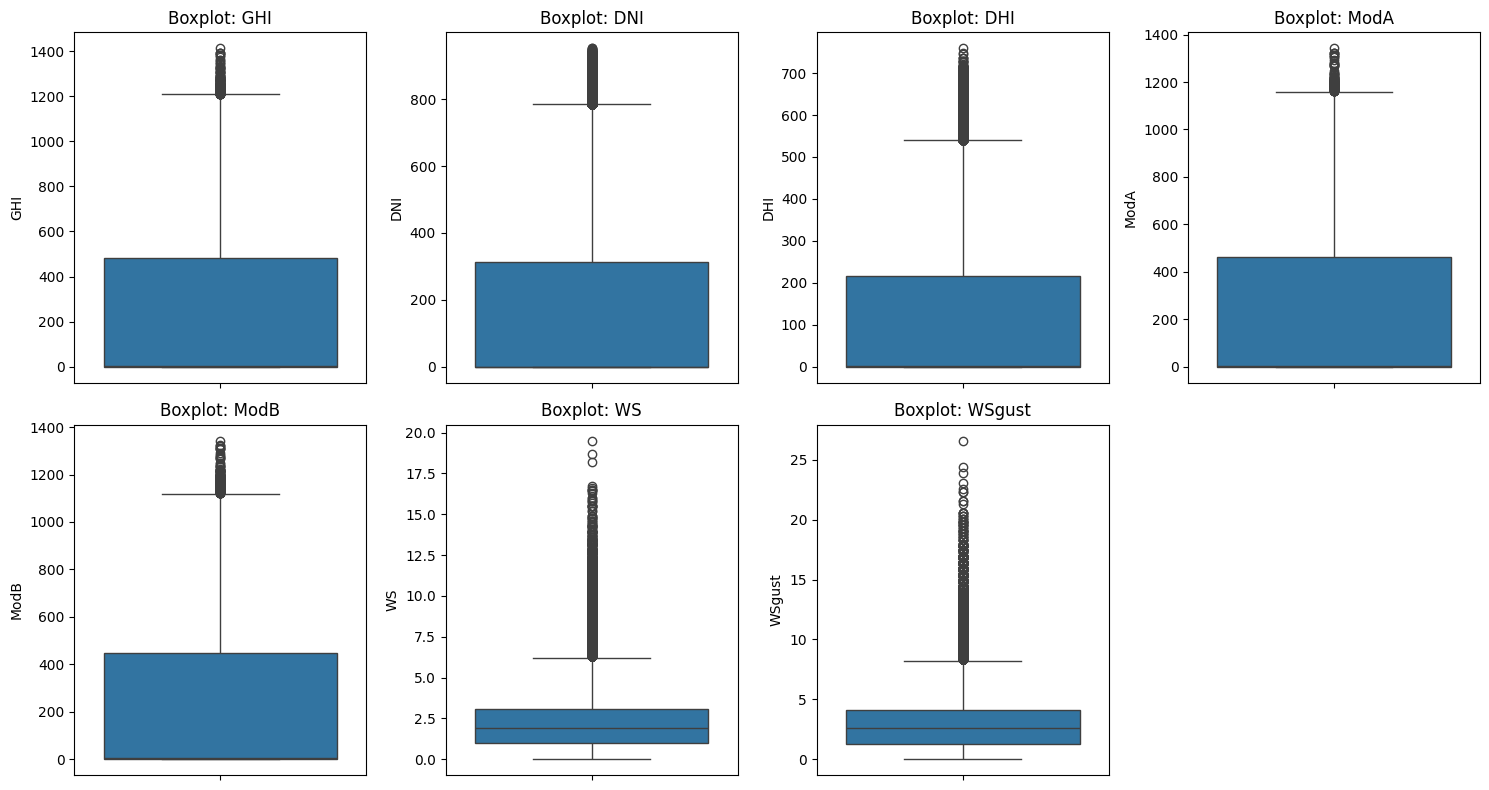

In [34]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(cols_to_check, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()

### Basic Cleaning

In [35]:
# Drop or fill missing values in key columns
df_clean = df.copy()
df_clean[cols_to_check] = df_clean[cols_to_check].fillna(df_clean[cols_to_check].median())

In [36]:
df_clean.to_csv('../data/benin_clean.csv', index=False)

### Time Series Analysis

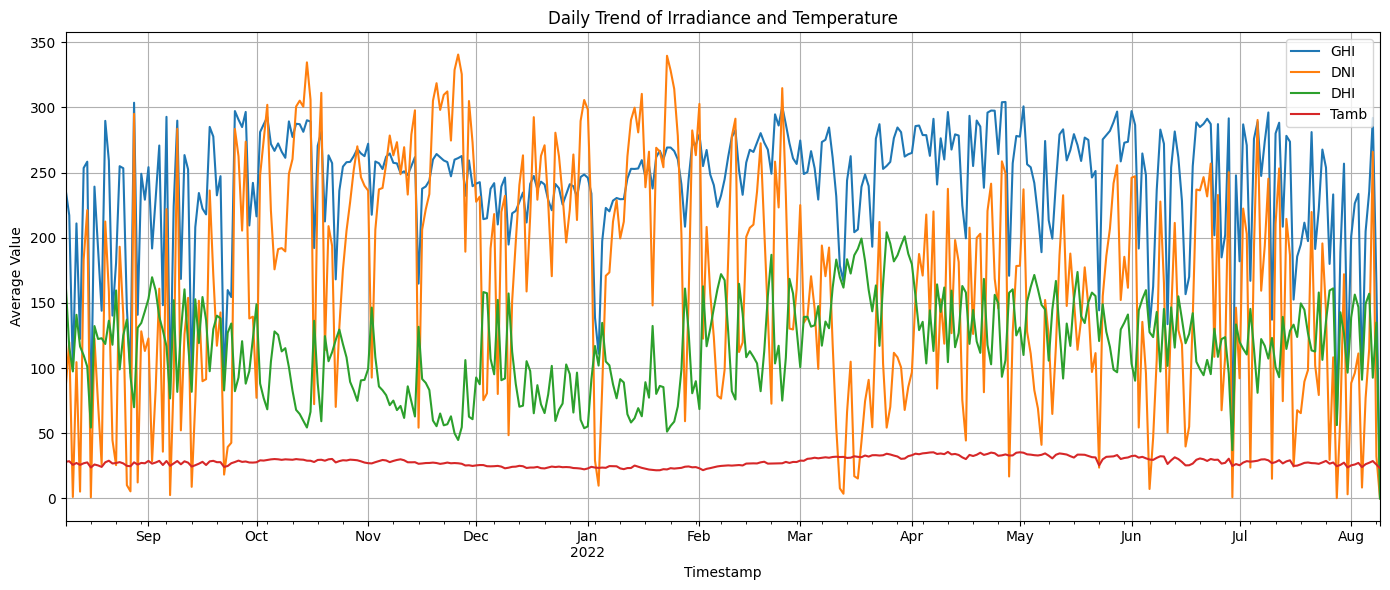

/tmp/ipykernel_38603/2305861896.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_clean[cols].resample('M').mean()


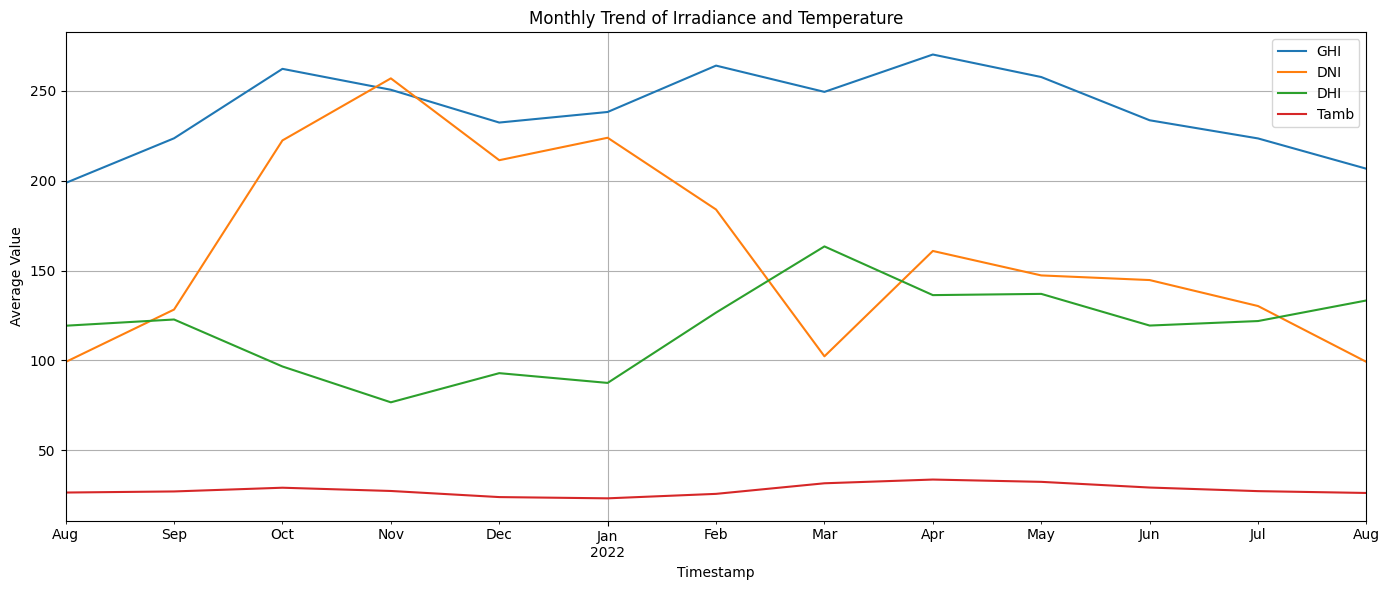

In [39]:
# Ensure Timestamp is datetime
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Set Timestamp as index
df_clean.set_index('Timestamp', inplace=True)

# Columns to visualize
cols = ['GHI', 'DNI', 'DHI', 'Tamb']

# ==== DAILY TREND ====
daily_avg = df_clean[cols].resample('D').mean()

plt.figure(figsize=(14, 6))
daily_avg.plot(ax=plt.gca())
plt.title('Daily Trend of Irradiance and Temperature')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== MONTHLY TREND ====
monthly_avg = df_clean[cols].resample('M').mean()

plt.figure(figsize=(14, 6))
monthly_avg.plot(ax=plt.gca())
plt.title('Monthly Trend of Irradiance and Temperature')
plt.ylabel('Average Value')
plt.grid(True)
plt.tight_layout()
plt.show()


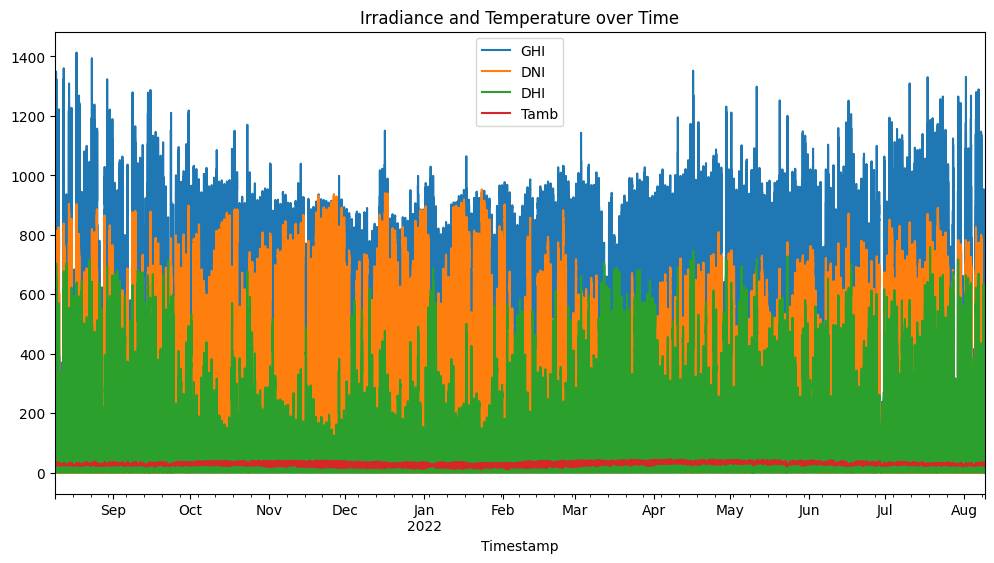

In [37]:
df_clean.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(figsize=(12, 6))
plt.title('Irradiance and Temperature over Time')
plt.show()

### Cleaning Impact Analysis

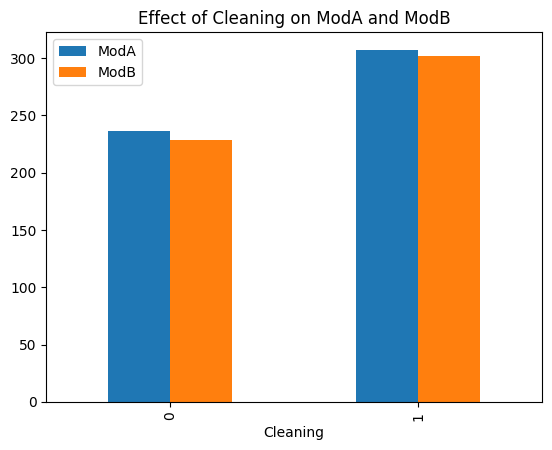

In [38]:
df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().plot(kind='bar')
plt.title('Effect of Cleaning on ModA and ModB')
plt.show()

### Correlation & Relationship Analysis

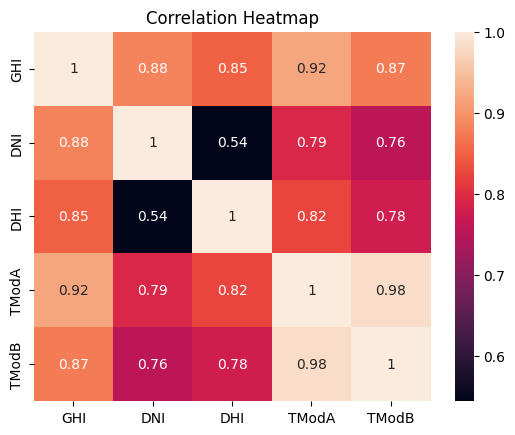

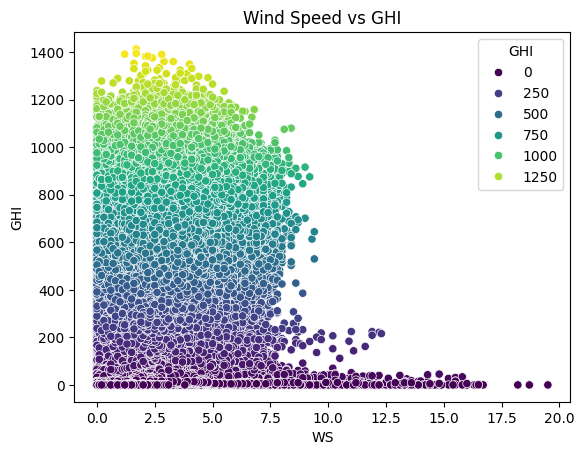

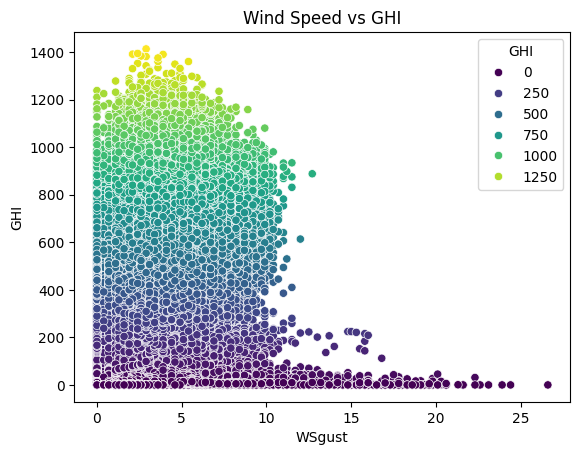

/home/samrawit/anaconda3/envs/mltraining/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


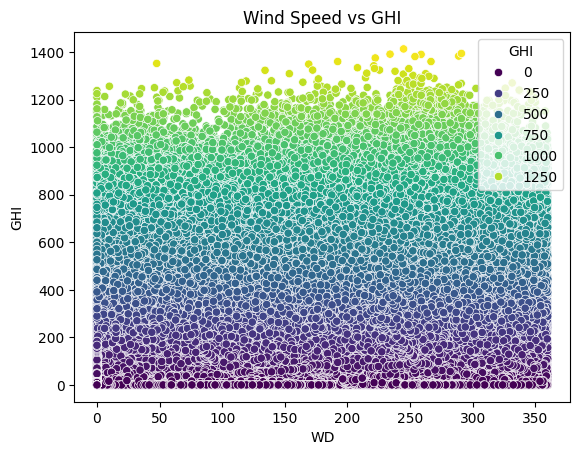

In [40]:
sns.heatmap(df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

sns.scatterplot(x='WS', y='GHI',  hue='GHI', palette='viridis', data=df_clean)
plt.title('Wind Speed vs GHI')
plt.show()

sns.scatterplot(x='WSgust', y='GHI',  hue='GHI', palette='viridis', data=df_clean)
plt.title('Wind Gust Speed vs GHI')
plt.show()

sns.scatterplot(x='WD', y='GHI',  hue='GHI', palette='viridis', data=df_clean)
plt.title('Wind Direction vs GHI')
plt.show()

### Wind & Distribution Analysis

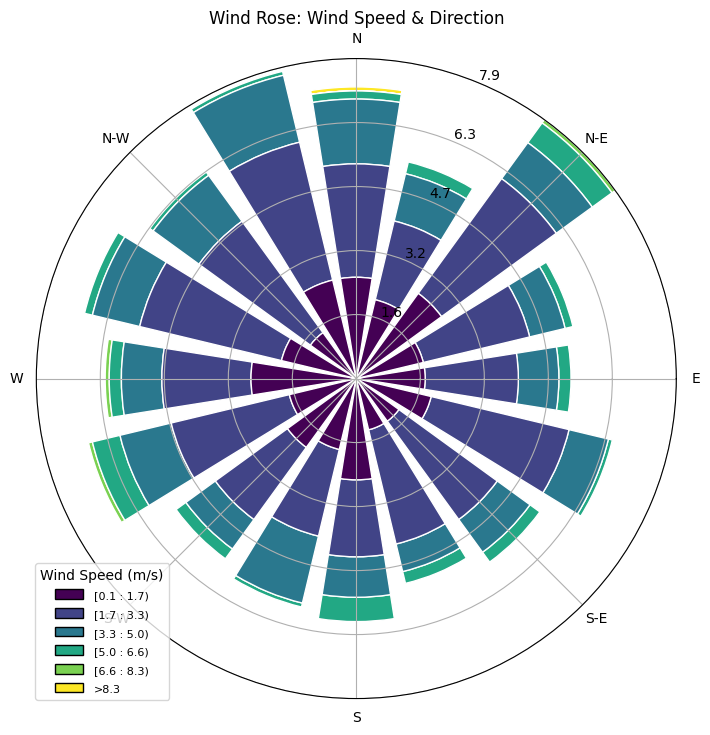

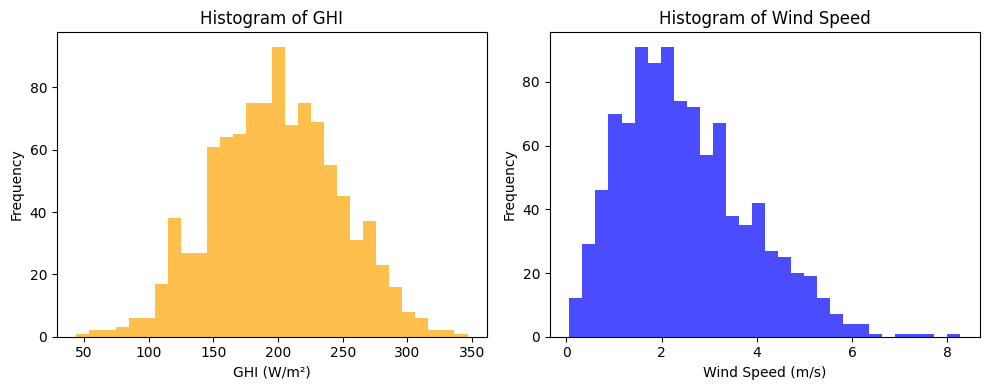

In [41]:
# Sample data (replace with your actual data)
# Assume you have pandas DataFrame df with columns 'WS' (wind speed), 'WD' (wind direction), 'GHI'

np.random.seed(0)
N = 1000
df = pd.DataFrame({
    'WS': np.random.rayleigh(scale=2, size=N),      # Wind Speed (m/s)
    'WD': np.random.uniform(0, 360, size=N),        # Wind Direction (degrees)
    'GHI': np.random.normal(loc=200, scale=50, size=N)  # GHI (W/m²)
})

# 1. Wind Rose plot
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title="Wind Speed (m/s)")
plt.title("Wind Rose: Wind Speed & Direction")
plt.show()

# 2. Histogram of GHI
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['GHI'], bins=30, color='orange', alpha=0.7)
plt.title("Histogram of GHI")
plt.xlabel("GHI (W/m²)")
plt.ylabel("Frequency")

# Histogram of WS
plt.subplot(1, 2, 2)
plt.hist(df['WS'], bins=30, color='blue', alpha=0.7)
plt.title("Histogram of Wind Speed")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### Temperature & RH Relationship

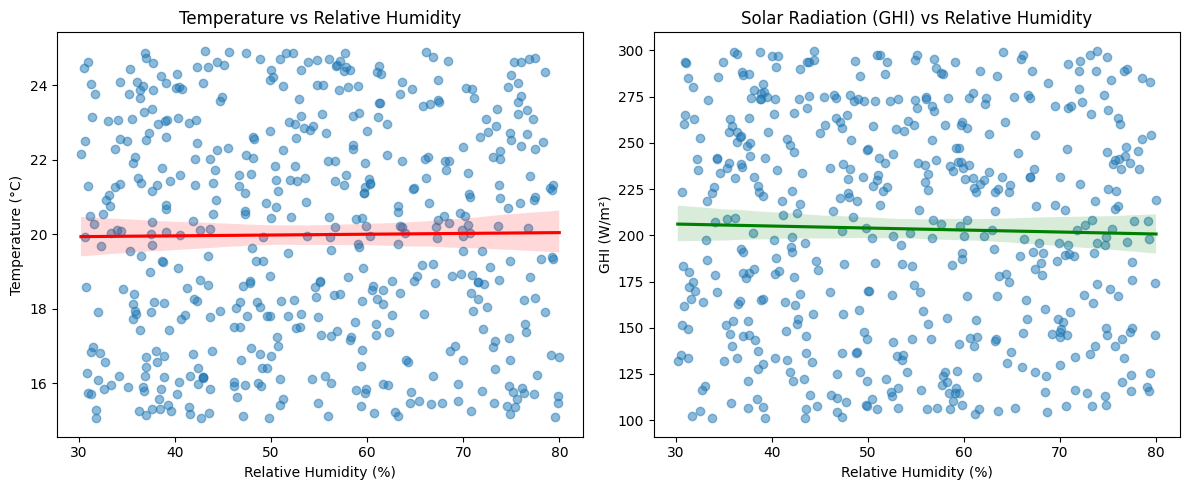

Pearson correlation between Temperature and RH: 0.010 (p=8.174e-01)
Spearman correlation between GHI and RH: -0.026 (p=5.603e-01)


In [44]:
# Example data (replace with your real dataset)
np.random.seed(42)
N = 500
df = pd.DataFrame({
    'Temperature': 15 + 10*np.random.rand(N),          # °C
    'RH': 30 + 50*np.random.rand(N),                   # %
    'GHI': 100 + 200*np.random.rand(N)                 # W/m²
})

# 1. Scatter plot with regression line: Temperature vs RH
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.regplot(x='RH', y='Temperature', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Temperature vs Relative Humidity")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")

# 2. Scatter plot with regression line: GHI vs RH
plt.subplot(1, 2, 2)
sns.regplot(x='RH', y='GHI', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.title("Solar Radiation (GHI) vs Relative Humidity")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("GHI (W/m²)")

plt.tight_layout()
plt.show()

# 3. Correlation coefficients
pearson_temp_rh = pearsonr(df['Temperature'], df['RH'])
spearman_ghi_rh = spearmanr(df['GHI'], df['RH'])

print(f"Pearson correlation between Temperature and RH: {pearson_temp_rh[0]:.3f} (p={pearson_temp_rh[1]:.3e})")
print(f"Spearman correlation between GHI and RH: {spearman_ghi_rh.correlation:.3f} (p={spearman_ghi_rh.pvalue:.3e})")


### Bubble Chart

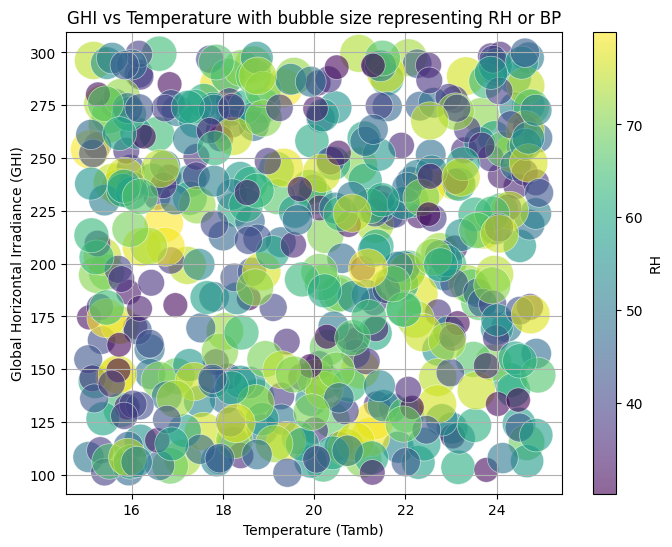

In [51]:
# Choose bubble size variable (RH or BP)
bubble_size = df['RH']  # or df['BP']

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df['Temperature'],   # x-axis: Temperature
    df['GHI'],           # y-axis: GHI
    s=bubble_size * 10,  # bubble size, multiplied to scale visibility
    alpha=0.6,
    c=bubble_size,       # color by bubble size for extra info (optional)
    cmap='viridis',      # color map
    edgecolors='w',
    linewidth=0.5
)
plt.colorbar(scatter, label='RH' if bubble_size.equals(df['RH']) else 'BP')
plt.xlabel('Temperature (Tamb)')
plt.ylabel('Global Horizontal Irradiance (GHI)')
plt.title('GHI vs Temperature with bubble size representing RH or BP')
plt.grid(True)
plt.show()
